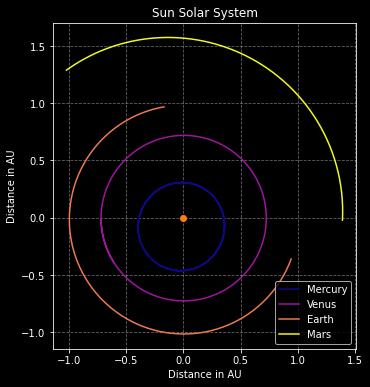

(244, 4, 2)
[[-0.09745642 -0.45552307]
 [-0.71644988 -0.06324054]
 [-0.20305178  0.96210196]
 [ 1.39155397  0.00950154]]


In [2]:
import numpy as np
import spiceypy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import datetime
import matplotlib.animation as animation
from IPython.display import HTML

spiceypy.furnsh("../_kernels/pck/gm_de431.tpc")
spiceypy.furnsh("../_kernels/lsk/naif0012.tls")
spiceypy.furnsh("../_kernels/spk/de432s.bsp")
# consts
start_date_utc = datetime.datetime(year=2000, month=1, day=1)
end_date_utc = datetime.datetime(year=2000, month=9, day=1)
start_date_et = spiceypy.utc2et(start_date_utc.strftime("%Y-%m-%dT00:00:00"))
end_date_et = spiceypy.utc2et(end_date_utc.strftime("%Y-%m-%dT00:00:00"))

year = 365*86400                            # sec in year [s]
au = 1.49598e11                             # AU in m     [m]
duration = (end_date_utc-start_date_utc).days*86400
t0 = 0.
nt = int(np.round(duration/86400,0))
t = np.linspace(t0,duration,nt)
legend_objects = []
legend_titles = []

class Planet:

    data_skip = 1

    def __init__(self, naifid, name, orbiting):
        self.name = name
        self.barrycenter_id = int(str(naifid)[0])
        self.state, self.r_sun = spiceypy.spkgeo(targ=self.barrycenter_id, et=start_date_et, \
                                    ref="ECLIPJ2000", obs=10)
        self.state = self.state*1000                        # km -> m
        self.parent = orbiting
        self.y = []
        self.line = []
        self.anim_data = []
        self.scat = []
        self.color = []
        orbiting.add_planet(self)
    
    def f(self, y, t, mstar):
        self.gm = solar_system.G*mstar
        self.x = y[0:3]
        self.v = y[3:]
        self.r = np.linalg.norm(self.x)
        self.dxdt = self.v
        self.dvdt = -self.gm*self.x/self.r**3
        self.dy = np.hstack((self.dxdt, self.dvdt))
        return self.dy
    
    def plot_orbit_2d(self):
        y = self.calculate_orbit()                      
        self.y = y
        self.line, = self.parent.ax.plot(y[:,0],y[:,1], color=self.color)
        self.line.set_label(self.name)
        legend_objects.append(self.line)
        legend_titles.append(self.name)
        return self.line, self.y

    def calculate_orbit(self):
        y = odeint(self.f, self.state,t, args=(self.parent.sun_mass,))
        y = y/au                                        # divide by AU 
        return y
    
    def make_scatter_for_animation(self):

        x = self.y[:,0]
        y = self.y[:,1]
        self.data = np.hstack((x[:,np.newaxis], y[:, np.newaxis]))

        return self.data
    
    def animate_orbit(self):
        data = self.make_scatter_for_animation()
        return data


    @classmethod
    def from_string(cls, planet_str):
        id, name, orbiting = planet_str.split('-')
        return cls(id, name, orbiting)

    
class solar_system:

    G = 6.67428e-11                             # m3 / kg / s^2
    def __init__(self, name, sun_mass):
        self.name = name
        self.sun_mass = sun_mass
        self.planets = []
        self.ax = []
        self.fig = []
        self.scat = []
        self.data = []

    
    def add_planet(self, planet):
        self.planets.append(planet)

    def create_space_map(self):
        plt.style.use("dark_background")
        fig, ax = plt.subplots(figsize=(8,6))
        ax.grid(linestyle="dashed", alpha=0.4)
        ax.set_title(self.name + " Solar System")
        ax.plot([0.],[0.],'o', color="tab:orange")
        ax.set_aspect("equal")
        ax.set_ylabel("Distance in AU")
        ax.set_xlabel("Distance in AU")
        return ax, fig
    
    def populate_ss(self):

        cmap = plt.get_cmap('plasma')
        colors = cmap(np.linspace(0, 1, len(self.planets)))
        j = 0

        for i in self.planets:
            i.color = colors[j]
            i.plot_orbit_2d()
            j+=1

    def animate_ss(self):

        num_planets = len(self.planets)
        self.data = np.zeros((nt, num_planets, 2))
        planet_no = 0
        
        for i in self.planets:
            data   = i.animate_orbit()
            for j in range(len(data)):
                for k in range(2):
                    self.data[j,planet_no,k] = data[j,k]
            global hei
            hei = self.data
            planet_no+=1


        def update_plot(i, data, scat):
            # num_planets = len(self.planets)
            scat.set_offsets(data[i])
            # for j in range(num_planets):
            #     scat.set_offsets(data[i,j])
            #     scat.set_array(self.planets[j].color)
            time = start_date_utc + datetime.timedelta(days=i)
            time_str = time.strftime("%Y-%m-%d")
            title.set_text("Date: " + time_str)
            return scat,title

        title = self.ax.text(0.97,0.97, "", ha="right", va="top", \
                                   transform=self.ax.transAxes)

        self.scat = self.ax.scatter([], [])
        ani = animation.FuncAnimation(self.fig, update_plot, frames=nt-1,\
            # interval=int(np.round(numframes/25,0)+1), fargs=(data, scat))
            interval=15, fargs=(self.data, self.scat))
        plt.show()
        print(np.shape(self.data))
        print(self.data[2,:])
        print(self.scat)
        return ani
        


# Let's add our solar system as an instance

Sun = solar_system("Sun", 1.98892e30)

# create our solar system and save Axes object as space_map
Sun.ax, Sun.fig = Sun.create_space_map()


mercury = Planet(199, "Mercury", Sun)
venus = Planet(299, "Venus", Sun)
earth = Planet(399, "Earth", Sun)
mars = Planet(499, "Mars", Sun)
# jupiter = Planet(599, "Jupiter", Sun)
# saturn = Planet(699, "Saturn", Sun)
# uranus = Planet(799, "Uranus", Sun)
# neptune = Planet(899, "Neptune", Sun)

Sun.populate_ss()
Sun.ax.legend(legend_objects, legend_titles)

animation = Sun.animate_ss()


# plt.savefig("hei.png")
# plt.close('all')

# def update_plot(i, data, scat):
#     scat.set_offsets(data[i,:])
#     return scat,

# numframes = len(earth.y)
# x = earth.y[:,0]
# y = earth.y[:,1]
# data = []
# data = np.hstack((x[:,np.newaxis], y[:, np.newaxis]))

# scat = space_map_ax.scatter([], [])

# ani = animation.FuncAnimation(space_map_fig, update_plot, frames=numframes-1,\
#     # interval=int(np.round(numframes/25,0)+1), fargs=(data, scat))
#     interval=15, fargs=(data, scat))

# plt.show()


In [3]:
HTML(animation.to_html5_video())